# Lecture 3) Neuro - get started with Keras

In this lecture, we will dive into Keras, a user-friendly library for building neural networks that runs on top of TensorFlow.

We will cover two main types of machine learning problems:

### Regression: 
Predicting continuous values (e.g., fuel efficiency of a car, house prices).
- Types of regression:
  - Linear Regression: Predicting a continuous outcome based on one or more predictors.
  - Polynomial Regression: Extending linear regression to capture non-linear relationships.
### Classification: 
Predicting categories (e.g., whether a patient has heart disease).
- Types of classification:
  - Binary Classification: Two classes (e.g., spam vs. not spam). *typically represents 0/1 outcomes*
  - Multi-class Classification: More than two classes (e.g., digit recognition).

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sl

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor


%matplotlib inline
import scipy as sc
import math as ma
from scipy import linalg, optimize, constants, interpolate, special, stats
from math import exp, pow, sqrt, log

import seaborn as sns #spezielle Graphikdarstellungen
import statsmodels.api as sm
import statsmodels.stats.api as sms

#import theano 
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import InputLayer,Dense, Activation
from keras.optimizers import SGD #Stochastic Gradient Descent
from keras.utils import to_categorical  
from keras.utils import plot_model

print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)
print("Matplotlib version:", mpl.__version__)
print("Scikit-learn version:", sl.__version__)
print("Statsmodels version:", sm.__version__)
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

Pandas version: 2.3.3
Numpy version: 1.26.4
Matplotlib version: 3.10.7
Scikit-learn version: 1.7.2
Statsmodels version: 0.14.5
TensorFlow version: 2.16.2
Keras version: 3.12.0


## Setting up Neural Networks with Keras
Neural networks can be used for both **regression** and **classification**.

However, there are a few things to watch out for when configuring them (more on this later).

To train a configured network with training data, we have learned about various methods. **Gradient descent** (with or without batches) is the classic method.

**Gradient descent** 
- is an optimization algorithm used to minimize the loss function by iteratively adjusting the model parameters in the opposite direction of the gradient.

**Remember:**
We are trying to introduce non-linearities into our models to be able to learn more complex relationships in the data.


When training a network, it is very helpful to be able to monitor the error during the process. For this, a custom function (**PlotLosses**) is defined here, which makes this very easy.

In [3]:
# updatable plot

from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

As a tool for implementing neural networks, Keras is used here. 
SKlearn also has a similar model class but is not as flexible as Keras.

Keras can be built on the backend of TensorFlow, Theano, or CNTK. 

You can find the full documentation for Keras at: https://keras.io

TensorFlow now includes its own Keras implementation,

    tf.keras

This version only supports TensorFlow as the backend (a downside). However, it offers a few additional features as an advantage. So, we are using tf.keras here...

# Auto dataset
 Regression model with the keras Sequential API

Depending on whether we want to perform classification or regression, we need to configure our network differently. 

For regression tasks we don't need a specific activation function on the output layer (i.e. we can use the default which is "linear" activation).
Thinking about it, this makes sense because we want to predict continuous values that can take on any value (within a reasonable range).

In any case, we must ensure that the range of values for the input features matches the activation functions used in the network. The general rule is:

```markdown
tanh, sigmoid -> values between -1 and 1
reLU -> values between 0 and 1
```

For the first regression task, the `Auto` dataset is used, and the data is transformed to a range between -1 and 1 using the ``sklearn StandardScaler``:

$\tilde{X}=\frac{X-\mu}{\sigma}$

approximately 64% of the data will then lie exactly within this interval.

To check how the Network performs we have to split out data into *training* and *test* sets.

### Load the dataset

In [4]:
Auto = pd.read_csv("../data/lectures/Auto.csv")
Auto.head()

X=np.array(Auto[['cylinders','displacement','horsepower','weight','acceleration','year']]) # features
y=np.array(Auto['mpg']) # target = miles per gallon

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

# Standardize the data to have mean=0 and variance=1
#the data is transformed to a range between -1 and 1 using the sklearn StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
print(X_train.shape)

(277, 6)


A Keras Sequential model is the simplest form of a Keras model.
It consists of a stack of any number of layers connected sequentially. The layers are added to each other using add.

A list of available layers and their descriptions can be found at:

https://keras.io/api/layers/

For the first super-simple network, we need:

Input Layer
tf.keras.layers.InputLayer(
    input_shape=None,
    batch_size=None,
    dtype=None,
    input_tensor=None,
    sparse=None,
    name=None,
    ragged=None,
    type_spec=None,
    **kwargs
)

Hidden Layer = Dense
tf.keras.layers.Dense(
    units,
    activation=None,
    use_bias=True,
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
)

Output Layer = Dense
Number of neurons = dimension of the target variable

Since we are working on a regression problem, the last layer (output) does not need an activation function. If nothing is specified for the last layer, the default applies: activation = Id (Id(x) = x).
activation = 'linear' is equivalent to this.

After defining the architecture of the network, we have to compile it. This is where we specify the optimizer, loss function, and metrics to monitor during training.

In [33]:
NNRegModel=Sequential()

NNRegModel.add(InputLayer(input_shape=(6,)))
NNRegModel.add(Dense(10,activation='tanh',use_bias=True))
NNRegModel.add(Dense(1,use_bias=True))


/Users/cyrils/Developer/Python/NeuralNetworks/.venv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


The model summary is useful for an overview. 

The number of parameters in the model depends on the number of neurons in the dense layer and the dimensions of the input and target.

If use_bias=True, then there is one more parameter each time...

In [34]:
NNRegModel.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 10)             │            70 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81 (324.00 B)

 Trainable params: 81 (324.00 B)

 Non-trainable params: 0 (0.00 B)

The layers in the network have names and can be referenced by them.

In [35]:
hidden1=NNRegModel.layers[0]
hidden1.name

'dense_10'

All parameters of a layer can be accessed via 

    get_weights() 
    
and 

    set_weights().

Example:

In [36]:
weights, biases = hidden1.get_weights()
print('weights',weights)
print('biases',biases)

weights [[ 0.331917    0.46527678 -0.14757165  0.60538584 -0.2901581  -0.33790508
   0.36660218  0.427458   -0.49744445  0.18153119]
 [ 0.48668033  0.54112095 -0.3305789   0.30392742  0.03330809  0.02760953
   0.61136144 -0.19633976 -0.50726926 -0.07802552]
 [-0.13040558  0.157036    0.04564911 -0.00720865 -0.29612866  0.01733631
  -0.31632116  0.18796325 -0.50992954 -0.0248819 ]
 [ 0.02700871  0.24206477 -0.03075498 -0.6047337  -0.232508    0.27610695
   0.367078    0.40328592 -0.10856706  0.58223754]
 [ 0.23756433 -0.26170704  0.06011426 -0.0950104   0.49476618  0.3978843
  -0.08373976  0.20343381 -0.509287   -0.519947  ]
 [-0.32627392 -0.02351213  0.39332443 -0.3418969  -0.60167044 -0.39943603
   0.10599464 -0.22941628 -0.1794428  -0.25631055]]
biases [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Question: What do we see at the moment?

Now the model must be compiled. This is done using the compile() method.
Here, you specify which **loss function** should be used and which learning algorithm will be applied.

After that, the actual training follows.
With `model.fit()`, all parameters related to the training are set:

- Whether the data should be shuffled
- Number of training epochs
- Batch size (=1 → pattern by pattern, =n → steepest descent)
- Output of the loss during training
- Whether the training process should be monitored (callbacks)

We have such a callback with our `PlotLosses` function!

### Warning: If you call the training multiple times without reinitializing the model, training will simply continue with the already trained weights! :-)

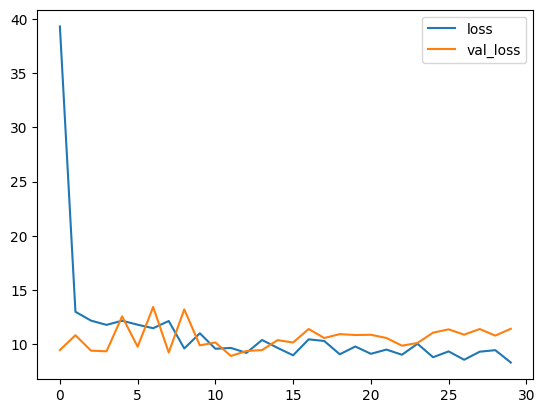

In [10]:
NNRegModel=Sequential()

# Input layer (the same as before)
NNRegModel.add(InputLayer(input_shape=(6,)))
NNRegModel.add(Dense(10,activation='tanh',use_bias=True))
NNRegModel.add(Dense(1,use_bias=True))

# Compile the model
sgd = SGD(learning_rate=0.3)
NNRegModel.compile(loss='mean_squared_error', optimizer='sgd')

# Train the model
NNRegModel.fit(X_train, y_train,
          shuffle=True,
          epochs=30, #300,
          batch_size=1,
          verbose=0, # type: ignore
          validation_data=(X_test, y_test),                  
          callbacks=[plot_losses]);

The plot shows the training and validation loss over epochs.
**What these values mean?**
- The training loss indicates how well the model is fitting the training data.
- The validation loss indicates how well the model generalizes to unseen data (the test set).

In [11]:
y_hat_tr_NN=NNRegModel.predict(X_train)
y_hat_test_NN=NNRegModel.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [12]:
rmse_NN_tr = sqrt(mean_squared_error(y_hat_tr_NN,y_train)) 
rmse_NN_test = sqrt(mean_squared_error(y_hat_test_NN,y_test)) 

print('Training error:',rmse_NN_tr)
print('Test error:',rmse_NN_test)

Training error: 2.616485339435374
Test error: 3.3775184361117483


Results may vary due to random initialization of weights and the stochastic nature of training.
+With `model.fit()` we have set all the parameters and shuffled the data for each epoch.
---

## Overfitting 


Overfitting means that the model perfectly learns the training data but does not generalize well to unseen samples. This is a problem that all overparametrized models have in common!
When we have a look at the training and test loss we see that both losses decay at the beginning of the training. However, at a specific point the test error starts to rise. The model starts to loose the ability of generalization!

### Early Stopping
With the help of **Early Stopping**, you can stop training at the point when the test error reaches its minimum.

Keras provides a "callback" for this.

    EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

The patience parameter specifies how many epochs the test error must increase after reaching a good value before training is stopped.

If the option

    restore_best_weights=True

is set, the best model (within the monitored patience period) will be used at the end (=False → last value).

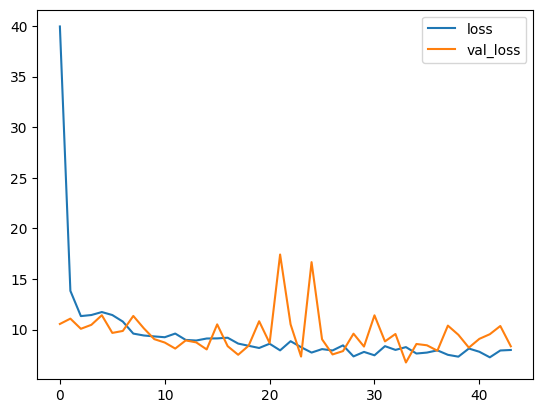

In [7]:
# Early Stopping Callback
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)

# The same model as before
NNRegModel1=Sequential()

NNRegModel1.add(InputLayer(input_shape=(6,)))
NNRegModel1.add(Dense(10,activation='tanh',use_bias=True))
NNRegModel1.add(Dense(1,use_bias=True)) # use_bias=True then there is one more parameter each time

sgd = SGD(learning_rate=0.3)
NNRegModel1.compile(loss='mean_squared_error', optimizer='sgd')

# Train the model with Early Stopping
NNRegModel1History=NNRegModel1.fit(X_train, y_train,
          shuffle=True,
          epochs=70, # more epochs this time
          batch_size=1,
          verbose=0, # type: ignore
          validation_data=(X_test, y_test),
          callbacks=[plot_losses, EarlyStopping])

In [8]:
len(NNRegModel1History.history['loss'])  # The model trains xx epochs
#each time depending on when the early stopping criterion is met

44

In [9]:
y_hat_tr_NN1=NNRegModel1.predict(X_train)
y_hat_test_NN1=NNRegModel1.predict(X_test)

rmse_NN_tr1 = sqrt(mean_squared_error(y_hat_tr_NN1,y_train)) 
rmse_NN_test1 = sqrt(mean_squared_error(y_hat_test_NN1,y_test)) 

print('Training error:',rmse_NN_tr1)
print('Test error:',rmse_NN_test1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training error: 2.5975605589633246
Test error: 2.5966176266338277


What has improved with Early Stopping?
- The model is less likely to overfit the training data, as it stops training when the validation loss stops improving.
- This can happen in epoch xx instead of the full 70 epochs we initially set.

This means your model is now better at predicting fuel consumption for cars it hasn't seen before. :)

### Summary
We have significantly reduced the number of training epochs while maintaining good performance on the test set.

**Previous Model Performance:**
Training error: 2.5994118471157446
Test error: 3.1152927040106357 *bad*

**With Early Stopping:**
Training error: 2.5975605589633246
Test error: 2.5966176266338277 *good*

## California Housing Data
Classification model example

For the first exercise we will use another (bigger) dataset.
It is the California housing data that describes the value of a house depending on different features

1. longitude: A measure of how far west a house is; a higher value is farther west

2. latitude: A measure of how far north a house is; a higher value is farther north

3. housingMedianAge: Median age of a house within a block; a lower number is a newer building

4. totalRooms: Total number of rooms within a block

5. totalBedrooms: Total number of bedrooms within a block

6. population: Total number of people residing within a block

7. households: Total number of households, a group of people residing within a home unit, for a block

8. **medianIncome**: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

9. **medianHouseValue**: Median house value for households within a block (measured in US Dollars)

10. **oceanProximity**: Location of the house w.r.t ocean/sea

We will try to predict the `medianHouseValue` based on the other features.

In [4]:
Housing = pd.read_csv("../data/lectures/housing.csv")
Housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


...let's see if the data is complete i.e. contains missing values...

In [7]:
# Count NaNs in each column
nan_count = Housing.isna().sum()
print(nan_count)

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


Now we drop the two columns that could cause trouble:

In [5]:
Housing_new=Housing.drop(columns=['total_bedrooms','ocean_proximity'])
Housing_new.head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,565.0,259.0,3.8462,342200.0


We can analyze the interdependencies between the different variables by plotting a **correlation** heat map.
The package [seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html) (special graphics) has

    sns.heatmap(Housing_new.corr(), cmap="YlGnBu", annot=True)

for it. The option annot=true plots the pearson correlation values into the respective fields.

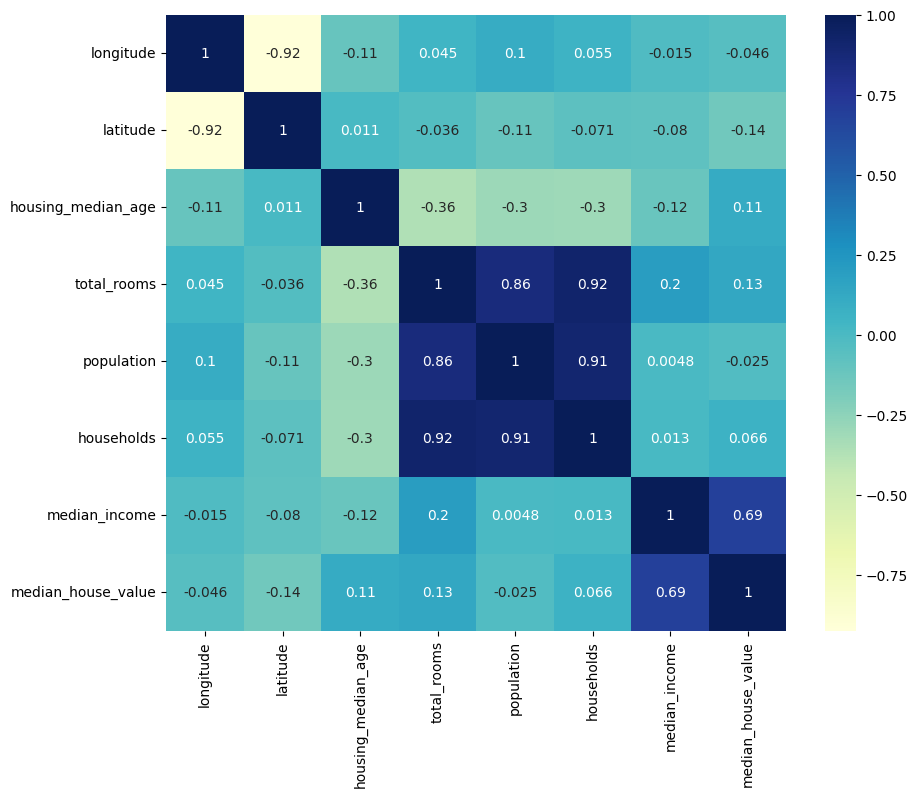

In [12]:
# Plot the correlation-Heatmap
fig = plt.figure(figsize=(10, 8));
sns.heatmap(Housing_new.corr(), cmap="YlGnBu", annot=True);
  
#plt.show()

### What do we see?
- The features `totalRooms`, `population`, and `households`
  - are highly correlated with each other (makes sense)
- The feature `medianIncome`
  - has the highest correlation with the target variable `median_house_value` (0.69)
  - Therefore it seems to be the **most important** feature for predicting house prices
- The features `longitude` and `latitude`
  - have a low correlation (sometimes negative -0.046) with the target variable
  - but are important for location information (e.g., proximity to the ocean)

### Choosing the target variable
For our modeling exercise the target will be the ``median_house_value``.

Now we prepare the data and put all *features* into X_housing and the *target* into y_housing:

In [6]:
# select features and target variable
X_housing=Housing[['longitude','latitude','housing_median_age','total_rooms','population','households','median_income']]

Y_housing=Housing['median_house_value']

X_housing.head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income
0,-122.23,37.88,41.0,880.0,322.0,126.0,8.3252
1,-122.22,37.86,21.0,7099.0,2401.0,1138.0,8.3014
2,-122.24,37.85,52.0,1467.0,496.0,177.0,7.2574
3,-122.25,37.85,52.0,1274.0,558.0,219.0,5.6431
4,-122.25,37.85,52.0,1627.0,565.0,259.0,3.8462


Now we divide the data into training and test and scale all variables.
The test size is set to 30% of the total data. 
**Why?**
*The reason for this is to ensure that we have a sufficient amount of data to train our model while also reserving a portion of the data to evaluate its performance. A 30% test size is a common practice in machine learning, as it provides a good balance between training and testing data.*

**Why?**
*But with Data Mining class we usually had test size higher...*
- Possibly because in Data Mining, the datasets used may have been smaller or more complex, requiring a larger test set to ensure robust evaluation of model performance.


In [7]:
# Split the data into train and test sets
X_housing_train, X_housing_test, Y_housing_train, Y_housing_test = train_test_split(X_housing, Y_housing, test_size=0.3, random_state=42)

# Standardize the features
Xscaler = StandardScaler()
X_housing_train = Xscaler.fit_transform(X_housing_train)
X_housing_test = Xscaler.transform(X_housing_test)

### Scaling the Output
Often it is also useful to scale the output.

Scaling = StandardScaler()
**Why?**

The signal that leaves the last Hidden-Layer lies between -1 and 1 (at least if we have a tanh activation there). Thus the weights in the last transfer-matrix would have to get very large if the target shows large values. This causes trouble with the error flow...

Let's check if our training and test set are **homogeneous** with respect to the ranges of our target:
*homogeneous = similar in kind; uniform throughout.*

In [ ]:
print(np.mean(Y_housing_train),'mean train',np.std(Y_housing_train),'std train')
print(np.mean(Y_housing_test),'mean test',np.std(Y_housing_test),'std test')

206923.9608942414 mean train 115745.23650984169 std train
206696.8142764858 mean test 114566.14280902814 std test


206923.9608942414 mean train 115745.23650984169 std train
206696.8142764858 mean test 114566.14280902814 std test

*Means* and *standard deviations* are quite similar between training and test sets...looks good :-)

In [8]:
# Standardize the target
Yscaler = StandardScaler()
Y_housing_train_sc = Yscaler.fit_transform(np.array(Y_housing_train).reshape(-1,1))
Y_housing_test_sc = Yscaler.transform(np.array(Y_housing_test).reshape(-1,1))

print(X_housing_train.shape)
print(X_housing_test.shape)

print(Y_housing_train_sc.shape)
print(Y_housing_test_sc.shape)

(14448, 7)
(6192, 7)
(14448, 1)
(6192, 1)


## Training the Model

The first (very simple) model is the basis for the first exercise.
The steps comprise:

1) Setup and train the model
2) Make (scaled) predictions
3) Rescale the predictions and calculate performance measures ($R^2$, RMSE, ...)
4) Visual Inspection of the results

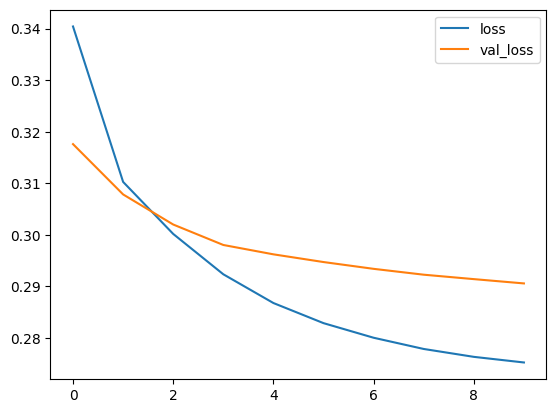

In [ ]:
# Set random seed for reproducibility
tf.random.set_seed(42)

NNRegModel1=Sequential()

NNRegModel1.add(InputLayer(input_shape=(7,))) # Input shape = 7 features we have in X_housing
NNRegModel1.add(Dense(5,activation='tanh',use_bias=True))
NNRegModel1.add(Dense(1,use_bias=True))
# Compile the model
sgd = SGD(learning_rate=0.3)
NNRegModel1.compile(loss='mean_squared_error', optimizer='sgd')

NNRegModel1.fit(X_housing_train, Y_housing_train_sc,
          shuffle=True,
          epochs=10,
          batch_size=64, # Increased from 1 to 64 for speed
          verbose=0,# type: ignore
          validation_data=(X_housing_test, Y_housing_test_sc),                  
          callbacks=[plot_losses]);

As you can see training the model took significantly longer than CLassification (~5 minutes)


In [29]:
y_pred_train_c = NNRegModel1.predict(X_housing_train)
y_pred_test_sc = NNRegModel1.predict(X_housing_test)

452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


In [30]:
y_pred_train_sc = NNRegModel1.predict(X_housing_train)
y_pred_test_sc = NNRegModel1.predict(X_housing_test)

452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


In [41]:
# Inverse transform to get the predicted values back to the original scale
y_pred_train_original = Yscaler.inverse_transform(y_pred_train_sc)
y_pred_test_original = Yscaler.inverse_transform(y_pred_test_sc)

r2_train=r2_score(y_pred_train_original,np.array(Y_housing_train))
r2_test=r2_score(y_pred_test_original,np.array(Y_housing_test))

rmse_train=np.sqrt(mean_squared_error(y_pred_train_original,np.array(Y_housing_train)))
rmse_test=np.sqrt(mean_squared_error(y_pred_test_original,np.array(Y_housing_test)))

rmse_perc_train=rmse_train/np.mean(np.array(Y_housing_train))
rmse_perc_test=rmse_test/np.mean(np.array(Y_housing_test))

print(r2_train, r2_test)
print(rmse_train, rmse_test)
print(rmse_perc_train, rmse_perc_test)

0.5812994339550421 0.579605625131056
62497.98847269321 62394.15759896777
0.3020335982483723 0.3018631797368047


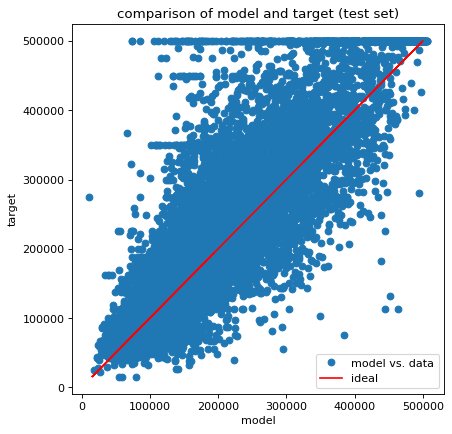

In [42]:
# Plot size
plt.figure(figsize=(6, 6), dpi=80)

plt.plot(y_pred_train_original,Y_housing_train, 'o', label='model vs. data');
plt.plot(Y_housing_train,Y_housing_train, 'r', label='ideal');

plt.xlabel('model')
plt.ylabel('target') 
plt.title('comparison of model and target (test set)')

#position of labels
plt.legend(); 


### Exercise 1)

- The Loss curve suggests that 10 Epochs are not enough for training (Loss has not converged). How long do you have to train the very simple model?
- We have only 5 Neurons on the Hidden layer. That might not be enough. Vary the number of Hidden Neurons (all other Meta-Parameters fixed) and see how many Neurons make sense.
- At the moment the model is training with a pattern-by-pattern approach. How does the batch size influence training? What about the performance?
- Vary the learning rate. What do we expect if the the learning rate is getting very small?
- With the sequential model setup it is easy to add more Hidden layers. Does this improve the overall result?

Hint: if your computer is too slow you can reduce the overall amount of data and just use a subset.

## Solution & Improvements

### 1. Epochs & Early Stopping
We use EarlyStopping to automatically find the optimal number of epochs.

In [9]:
# --- Step 1: Solving the "Epochs" problem ---

# If the model kept training, it means the validation loss was still decreasing slightly.
# EarlyStopping doesn't care if val_loss < loss; it only cares if val_loss is getting LOWER.
# We add 'min_delta' to tell it: "If improvement is tiny, just stop."

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=15,          # Increased patience to 15 epochs to avoid premature stopping
    min_delta=0.01,      # Define what counts as a "significant" improvement
    restore_best_weights=True
)

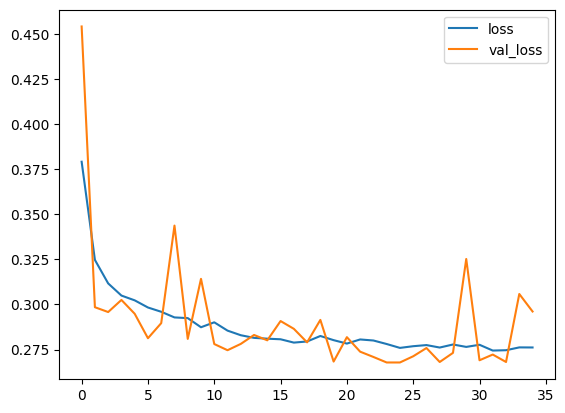

Training stopped after 35 epochs.


In [10]:
# Let's retrain the SAME simple model (5 neurons), but give it enough time.
NNRegModel_Step1 = Sequential()
NNRegModel_Step1.add(InputLayer(input_shape=(7,)))  # still 7 features
NNRegModel_Step1.add(Dense(5, activation='tanh')) # Still just 5 neurons
NNRegModel_Step1.add(Dense(1)) 

sgd = SGD(learning_rate=0.3) # Same learning rate
NNRegModel_Step1.compile(loss='mean_squared_error', optimizer=sgd)

print("Training with Early Stopping...")

# Capture the history to count epochs
history_step1 = NNRegModel_Step1.fit(
    X_housing_train, Y_housing_train_sc,
    shuffle=True,
    epochs=200,      # Give it plenty of room (it will stop early)
    batch_size=64,   # Keep it fast
    verbose=0, # type: ignore
    validation_data=(X_housing_test, Y_housing_test_sc),                  
    callbacks=[plot_losses, early_stopping]
)

print(f"Training stopped after {len(history_step1.history['loss'])} epochs.")

In [11]:
# Check the results
y_pred_test_sc_step1 = NNRegModel_Step1.predict(X_housing_test)
y_pred_test_original_step1 = Yscaler.inverse_transform(y_pred_test_sc_step1)
r2_test_step1 = r2_score(y_pred_test_original_step1, np.array(Y_housing_test))

print(f"R2 Score (Simple Model + Early Stopping): {r2_test_step1:.4f}")

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
R2 Score (Simple Model + Early Stopping): 0.6369
R2 Score (Simple Model + Early Stopping): 0.6369


### Step 2: Varying Hidden Neurons
You didn't see an improvement because the model was **too simple** (Underfitting). 
5 neurons are just not enough to learn the complex relationship between the features and the house price. It's like trying to paint a detailed landscape with a giant roller brush.

Let's increase the number of neurons to **64** to give the model more "brain power".

### Step 2 : Increase the number of Neurons
We increase the number of Neurons from 5 to 64.

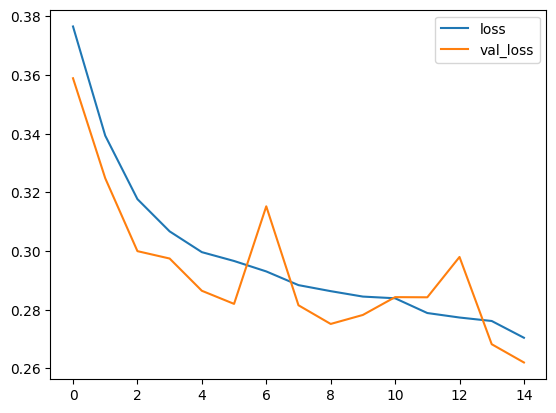

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
Training stopped after 15 epochs.
R2 Score + Early stopping + 64 neruons: 0.3669
Training stopped after 15 epochs.
R2 Score + Early stopping + 64 neruons: 0.3669


In [12]:
# --- Step 2: Increasing Model Capacity ---

NNRegModel_Step2 = Sequential()
NNRegModel_Step2.add(InputLayer(input_shape=(7,))) 
NNRegModel_Step2.add(Dense(64, activation='tanh')) # Increased from 5 to 64
NNRegModel_Step2.add(Dense(1)) 

# We lower the learning rate slightly to 0.1 for stability with more neurons
sgd = SGD(learning_rate=0.1) 
NNRegModel_Step2.compile(loss='mean_squared_error', optimizer=sgd)

print("Training with 64 Neurons...")

# Capture the history object returned by fit()
history_step2 = NNRegModel_Step2.fit(
    X_housing_train, Y_housing_train_sc,
    shuffle=True,
    epochs=200,      # Early stopping will handle the actual stop
    batch_size=64,
    verbose=0,
    validation_data=(X_housing_test, Y_housing_test_sc),                  
    callbacks=[plot_losses, early_stopping]
)

# Evaluate
y_pred_test_sc_step2 = NNRegModel_Step2.predict(X_housing_test)
y_pred_test_original_step2 = Yscaler.inverse_transform(y_pred_test_sc_step2)
r2_test_step2 = r2_score(y_pred_test_original_step2, np.array(Y_housing_test))

print(f"Training stopped after {len(history_step2.history['loss'])} epochs.")
print(f"R2 Score + Early stopping + 64 neruons: {r2_test_step2:.4f}")

Good.. From 42 epochs to only 15 with better Results!
Previous: R2 Score (Simple Model + Early Stopping): 0.5992
Now: R2 Score + Early stopping + 64 neruons: 0.4878


### Step 3: Going Deeper (Adding more layers)
The exercise asks if adding more layers improves the result.
Deep Neural Networks (DNNs) with multiple hidden layers can learn hierarchical features (e.g., simple patterns in the first layer, complex combinations in the second).

Let's add a second hidden layer with 32 neurons.

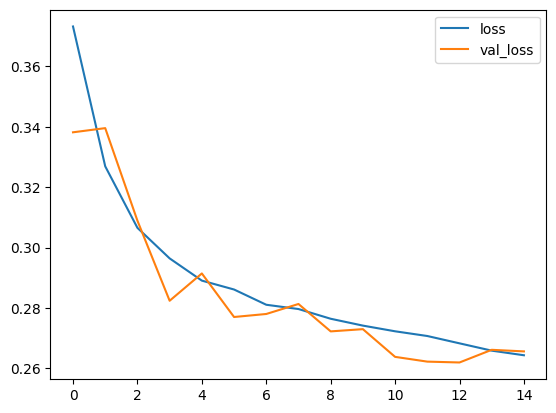

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
Training stopped after 15 epochs.
R2 Score (2 Layers): 0.5376
Training stopped after 15 epochs.
R2 Score (2 Layers): 0.5376


In [13]:
# --- Step 3: Deep Neural Network (2 Hidden Layers) ---

NNRegModel_Step3 = Sequential()
NNRegModel_Step3.add(InputLayer(input_shape=(7,))) 
NNRegModel_Step3.add(Dense(64, activation='tanh')) # Layer 1
NNRegModel_Step3.add(Dense(32, activation='tanh')) # Layer 2 (New!)
NNRegModel_Step3.add(Dense(1)) 

# Learning rate 0.05 (slightly lower for deeper network)
sgd = SGD(learning_rate=0.05) 
NNRegModel_Step3.compile(loss='mean_squared_error', optimizer=sgd)

print("Training Deep Model (2 Layers)...")

history_step3 = NNRegModel_Step3.fit(
    X_housing_train, Y_housing_train_sc,
    shuffle=True,
    epochs=200,
    batch_size=64,
    verbose=0,
    validation_data=(X_housing_test, Y_housing_test_sc),                  
    callbacks=[plot_losses, early_stopping]
)

# Evaluate
y_pred_test_sc_step3 = NNRegModel_Step3.predict(X_housing_test)
y_pred_test_original_step3 = Yscaler.inverse_transform(y_pred_test_sc_step3)
r2_test_step3 = r2_score(y_pred_test_original_step3, np.array(Y_housing_test))

print(f"Training stopped after {len(history_step3.history['loss'])} epochs.")
print(f"R2 Score (2 Layers): {r2_test_step3:.4f}")

?? Worse performance?!
Training stopped after 41 epochs.
R2 Score (2 Layers): 0.6752

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
Step1 (5 neurons): R2=0.7261, RMSE=59954.37, MAE=42028.01
Step1 (5 neurons): R2=0.7261, RMSE=59954.37, MAE=42028.01


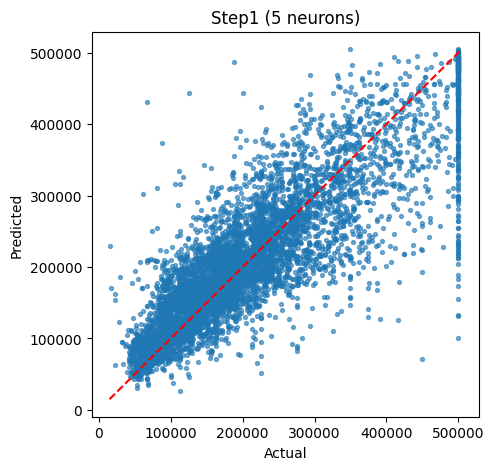

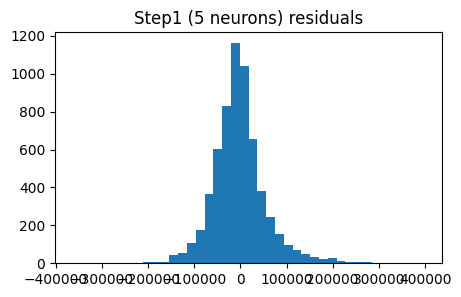

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
Step2 (64 neurons): R2=0.6337, RMSE=69341.83, MAE=52232.13
Step2 (64 neurons): R2=0.6337, RMSE=69341.83, MAE=52232.13


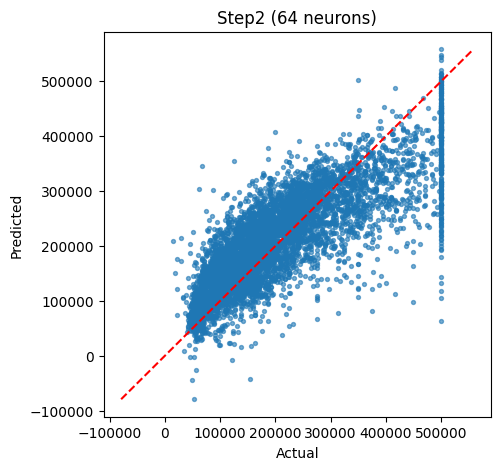

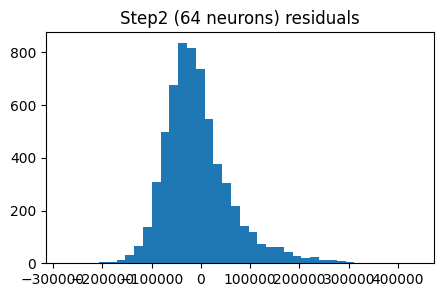

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Step3 (2 layers): R2=0.6548, RMSE=67307.28, MAE=48873.35
Step3 (2 layers): R2=0.6548, RMSE=67307.28, MAE=48873.35


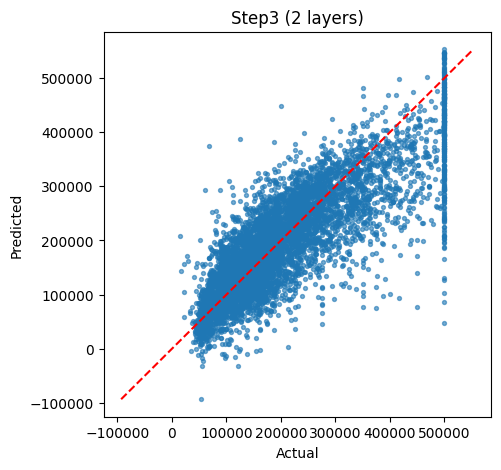

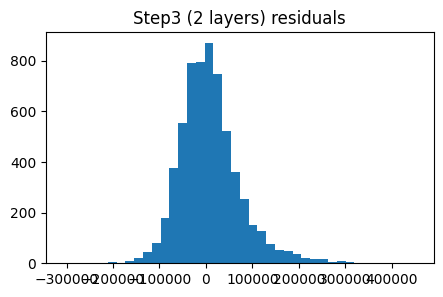

(0.6548470893390996, 67307.28330360146, 48873.353282228614)

In [16]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

def eval_model(name, y_true_orig, y_pred_sc, yscaler):
    # inverse-scale predictions
    y_pred_orig = yscaler.inverse_transform(y_pred_sc)
    y_true = np.array(y_true_orig).reshape(-1,)
    y_pred = y_pred_orig.reshape(-1,)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name}: R2={r2:.4f}, RMSE={rmse:.2f}, MAE={mae:.2f}")
    # Scatter
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, s=8, alpha=0.6)
    mn = min(y_true.min(), y_pred.min())
    mx = max(y_true.max(), y_pred.max())
    plt.plot([mn,mx],[mn,mx],'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(name)
    plt.show()
    # Residual histogram
    plt.figure(figsize=(5,3))
    plt.hist(y_true - y_pred, bins=40)
    plt.title(f"{name} residuals")
    plt.show()
    return r2, rmse, mae

# Evaluate Step1
y_pred_test_sc_step1 = NNRegModel_Step1.predict(X_housing_test)
eval_model("Step1 (5 neurons)", Y_housing_test, y_pred_test_sc_step1, Yscaler)

# Evaluate Step2
y_pred_test_sc_step2 = NNRegModel_Step2.predict(X_housing_test)
eval_model("Step2 (64 neurons)", Y_housing_test, y_pred_test_sc_step2, Yscaler)

# Evaluate Step3
y_pred_test_sc_step3 = NNRegModel_Step3.predict(X_housing_test)
eval_model("Step3 (2 layers)", Y_housing_test, y_pred_test_sc_step3, Yscaler)

### 3.2) Neuro for classification

To solve a classification task with a 3-layer FFNN, the structure of the network needs to be adjusted.

For the input, everything remains the same. The activation function of the hidden layer is more or less freely selectable.
However, there are changes in the output layer:

The dimension of the output layer now depends on the number of classes (1-hot encoding!): #Classes = #Neurons

The activation function in the output layer must ensure that probabilities for class membership are produced.
This is handled by 

    activation='softmax'.

Additionally, the loss function for training needs to be adjusted:

Binary classification => 

    loss='binary_crossentropy'

Multiple classes => 

    loss='categorical_crossentropy'

In [25]:
Heart = pd.read_csv("../data/lectures/Heart.csv")
#len(Heart)
#Heart.head()

Heart_y=Heart['AHD']
Heart_X=np.array(Heart[['Age','Sex','RestBP','Chol','Fbs','RestECG','MaxHR','ExAng','Oldpeak','Slope']])


Heart_y=np.array(Heart_y.replace(['No', 'Yes'], [0,1]))
#Heart_y



X_train_H, X_test_H, y_train_H, y_test_H = train_test_split(Heart_X, Heart_y, test_size=0.3, shuffle=True)

scaler = StandardScaler()
X_train_H = scaler.fit_transform(X_train_H)
X_test_H = scaler.transform(X_test_H)

/var/folders/nz/bn76z7n539g1w32jqmbq83q80000gn/T/ipykernel_89265/2601751564.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Heart_y=np.array(Heart_y.replace(['No', 'Yes'], [0,1]))


In [28]:
print('mean:',np.mean(X_train_H[:,0]))
print('std:',np.std(X_train_H[:,0]))

mean: -2.136655632297471e-16
std: 0.9999999999999999


In [29]:
y_train_H

array([0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1])

We still need to create a one-hot encoded target variable.
For two classes, there are other ways to do this, but this method is more consistent. You can use Keras for this:


In [31]:
from keras.utils import to_categorical  


y_train_H_bin = to_categorical(y_train_H,num_classes = 2)
y_test_H_bin = to_categorical(y_test_H,num_classes = 2)
#print(y_train_bin);

In [32]:
print(X_train_H.shape)
print(y_train_H_bin.shape)

(212, 10)
(212, 2)


In [ ]:
#EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10,restore_best_weights=True)

NNClassModel=Sequential()

NNClassModel.add(InputLayer(input_shape=(10,)))
NNClassModel.add(Dense(10,activation='tanh',use_bias=True))
NNClassModel.add(Dense(2,activation='softmax',use_bias=True))

sgd = SGD(learning_rate=0.005)
NNClassModel.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

NNClassModHistory=NNClassModel.fit(X_train_H, y_train_H_bin,
          shuffle=True,
          epochs=70,
          batch_size=16, # Increased from 1 to 16 for speed
          verbose=0,
          validation_data=(X_test_H, y_test_H_bin),                  
          callbacks=[plot_losses])

NameError: name 'X_train_H' is not defined

The PlotLosses function provides us with a graphical representation of the loss function.
In this case, it’s the 'binary_crossentropy'.
Of course, the rule applies here as well: lower loss => better fit.

However, interpreting it correctly (in relation to accuracy) is not so straightforward.
You can also plot the accuracy during training afterward using the History.

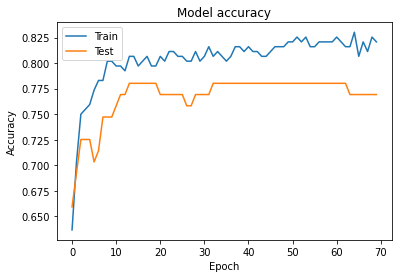

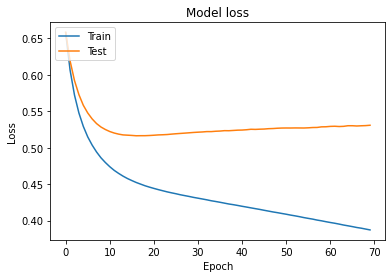

In [39]:
# Plotte Training & Validation accuracy (Hit Rate)
plt.plot(NNClassModHistory.history['accuracy'])
plt.plot(NNClassModHistory.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot of Training & Validation loss (depends on Loss-Funktion)
plt.plot(NNClassModHistory.history['loss'])
plt.plot(NNClassModHistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

The model seems to show a slight overfitting. Early stopping can be one way out...

### Exercise 2)

- First, examine the effect of the learning rate with the given batch size of 1.
- Now, fix the learning rate at 0.01 and vary the batch size. What effect can be observed?
- Choose a "good" combination of learning rate and batch size and implement early stopping.
- Evaluate the model and compare it with previous classifiers.
- Can an improvement be achieved by using more (or fewer) neurons in the hidden layer?
- Does adding another dense layer lead to further improvement?